**Nama  : Ridwan Akmal <br>**
          *MSIB 3 DICODING SUBMISSION Natural Language Processing* 

Melakukan import package-package penting yang akan digunakan

In [1]:
import sys, os, re, csv, numpy as np, pandas as pd, matplotlib.pyplot as plt
%matplotlib inline


import io
from google.colab import files


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Sequential


from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Mengupload file dari directory lalu memanggil dengan memanfaatkan package pandas

In [2]:
upload = files.upload()

Saving kaggle_movie_train.csv to kaggle_movie_train.csv


Melihat 5 data awal dari dataset yang kita miliki

In [3]:
# Load Tweet dataset
df = pd.read_csv(io.BytesIO(upload['kaggle_movie_train.csv']))
# Output first five rows
df.head()

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama


Menghitung jumlah persebaran data film berdasarkan genre

In [4]:
df['genre'].value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

Dari perolehan data tersebut kita akan kurangi menjadi hanya 4 genre saja yaitu comedy, action, horror, serta adventure.

In [5]:
# Menghapus genre selain 4 genre tersebut
df = df[~df['genre'].isin(['drama','thriller','sci-fi','other','romance'])]

In [6]:
df['genre'].value_counts()

comedy       2941
action       2392
horror        456
adventure     147
Name: genre, dtype: int64

Memanfaatkan penggunaan regex yang di mapping dengan lambda function agar terbebas dari tanda-tanda baca/special char yang kurang bermakna

In [7]:
# Menghapus special character di kolom text
df['Text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))
# drop kolom id dan text lama
df = df.drop(['id', 'text'], axis=1)
df.head()

,genre,Text
1,comedy,t summa cum laude and all And I m about to lau...
9,action,e reels as the world spins Sweat pours off him...
20,comedy,I say he s a man who ll go far Some people sa...
25,comedy,you find out where the bachelor party is COLE ...
29,comedy,ibly horrendous public break up on the quad Ag...


In [8]:
# mengecek apakah ada nilai NaN
df.isna().sum()

genre    0
Text     0
dtype: int64

In [9]:
# melakukan encoding pada label genre
genre = pd.get_dummies(df.genre)

In [10]:
df_genre = pd.concat([df, genre], axis=1)
df_genre = df_genre.drop(columns='genre')
df_genre.head()

,Text,action,adventure,comedy,horror
1,t summa cum laude and all And I m about to lau...,0,0,1,0
9,e reels as the world spins Sweat pours off him...,1,0,0,0
20,I say he s a man who ll go far Some people sa...,0,0,1,0
25,you find out where the bachelor party is COLE ...,0,0,1,0
29,ibly horrendous public break up on the quad Ag...,0,0,1,0


In [11]:
# melakukan transformasi tipe data menjadi string dan array 
text = df_genre['Text'].astype(str)
label = df_genre[['action', 'comedy','horror','adventure']].values

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_genre, test_genre, label_train, label_test = train_test_split(text, label, test_size = 0.2)

In [14]:
# mengkonversikan ke sequence
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(train_genre) 
tokenizer.fit_on_texts(test_genre)
 
sequences_train = tokenizer.texts_to_sequences(train_genre)
sequences_test = tokenizer.texts_to_sequences(test_genre)
 
padded_train = pad_sequences(sequences_train) 
padded_test = pad_sequences(sequences_test)

Melakukan deep learning workflow dari mulai penyusunan model dan criterion serta memilih optimizer dan menyesuaikan metrics

In [15]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [16]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [17]:
Adam(learning_rate=0.001, name='Adam')
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

Membuat class untuk callback dan melakukan mekanisme epoch didalam class

In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85 and logs.get('val_accuracy')>0.85):
      print("\nAkurasi train dan validasi yang kita dapatkan telah sesuai yaitu lebih dari 85%!")
      self.model.stop_training = True
callbacks = myCallback()

In [19]:
num_epochs = 30
history = model.fit(padded_train, label_train, epochs=num_epochs, validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
149/149 - 10s - loss: 1.0600 - accuracy: 0.4808 - val_loss: 0.9945 - val_accuracy: 0.4756 - 10s/epoch - 67ms/step
Epoch 2/30
149/149 - 2s - loss: 0.8839 - accuracy: 0.5470 - val_loss: 0.6306 - val_accuracy: 0.7357 - 2s/epoch - 12ms/step
Epoch 3/30
149/149 - 2s - loss: 0.4773 - accuracy: 0.8248 - val_loss: 0.4737 - val_accuracy: 0.8350 - 2s/epoch - 12ms/step
Epoch 4/30
149/149 - 2s - loss: 0.3497 - accuracy: 0.8692 - val_loss: 0.5563 - val_accuracy: 0.7828 - 2s/epoch - 11ms/step
Epoch 5/30

Akurasi train dan validasi yang kita dapatkan telah sesuai yaitu lebih dari 85%!
149/149 - 2s - loss: 0.1443 - accuracy: 0.9480 - val_loss: 0.3435 - val_accuracy: 0.8998 - 2s/epoch - 11ms/step


Membuat plot accuracy dan lossnya supaya mendapatkan insight dari hasil training kita

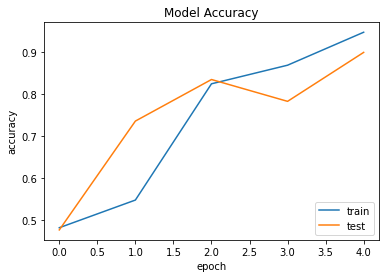

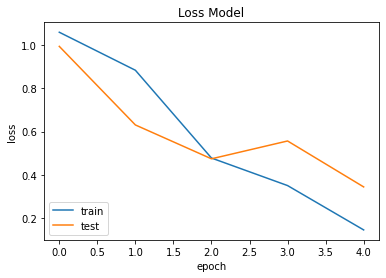

In [20]:
# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()